# <center> New York City Taxi Trip Duration


**[kaggle competition](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview)**

**На основе индивидуальных характеристик поездки следует спрогнозировать продолжительность поездки на такси в Нью-Йорке. Данные предоставлены комиссией по такси и лимузинам Нью-Йорка.**

## <center> Data

* **id** - ID поездки
* **vendor_id** - Фирма, организующая поездку
* **pickup_datetime** - Дата начала поездки
* **dropoff_datetime** - Дата окончания поездки (В правилах соревнования указано, что данный фактор использовать нельзя, в дальнейшем удалим его)
* **passenger_count** - Количество пассажиров
* **pickup_longitude** - Долгота начала поездки
* **pickup_latitude** - Широта начала поездки
* **dropoff_longitude** - Долгота окончания поездки
* **dropoff_latitude** - Широта окончания поездки
* **store_and_fwd_flag** - Этот флаг указывает, хранилась ли запись поездки в памяти транспортного средства перед отправкой поставщику (Фирма)
* **trip_duration** - Продожительность поездки в секундах

В соревновании используется RMSLE, как метрика качества:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$


In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipyleaflet import Map, Circle, LayerGroup, basemaps
from haversine import haversine, Unit
from IPython.display import Image

%matplotlib inline

sns.set(style="darkgrid")

In [2]:
train = pd.read_csv('data/train.csv').drop('dropoff_datetime', axis = 1)
test = pd.read_csv('data/test.csv')

In [3]:
train_index = len(train)
test_index = len(test)

In [4]:
data = pd.concat([train,test])

In [5]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [7]:
# Общая информация (тип данных, проверка на пропущенные значения)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 111.3+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


Распределение длительности поездки

<AxesSubplot:>

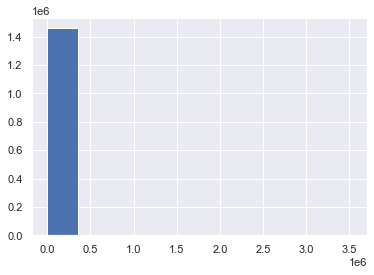

In [9]:
train['trip_duration'].hist()

Распределение имеет тяжелый правый хост, проделаем следующий трюк, будем предсказывать логарифм длительности поездки. В дальнейшем, чтобы получить обратно длительность поездки, можно взять экспоненту от преобразованного таргета и восстановить значения.

$\hat{y}_i = \log{(y + 1)}$ - модифицированный таргет,  $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета.

$a(x_i) = \exp(\hat{a}(x_i)) - 1$.

Заметим следующий факт, в соревновании в качестве метрики используют RMSLE. Мы модифицировали наш таргет, соответственно параметры модели будут подбираться так, чтобы минимизировать MSE, т.к. оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.


In [10]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])

<AxesSubplot:xlabel='log_trip_duration', ylabel='Density'>

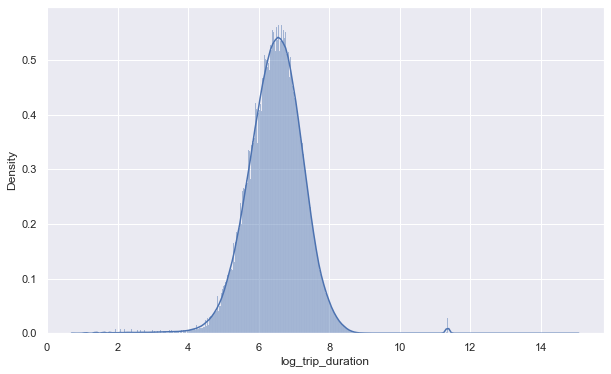

In [11]:
# Распределение модифицированного таргета
plt.figure(figsize = (10,6))

sns.histplot(data = train, x = 'log_trip_duration', stat = 'density', kde = True, )

# <center> EDA and Feature Engineering

## Part 1. `pickup_datetime`

$\text{pickup_datetime}$ имеет формат object, преобразуем в datetime.

In [12]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

**Для начала посмотрим на количество поездок в каждый из дней**

In [13]:
# pickup_date: yyyy-mm-dd
train['pickup_date'] = train['pickup_datetime'].dt.date
test['pickup_date'] = test['pickup_datetime'].dt.date

In [14]:
# Количество поездок в каждый из дней
num_trips_date = train\
                    .groupby('pickup_date', as_index = False)\
                    .agg({'id':'count'})\
                    .rename(columns = {'id':'num_trips'})

<AxesSubplot:xlabel='pickup_date', ylabel='num_trips'>

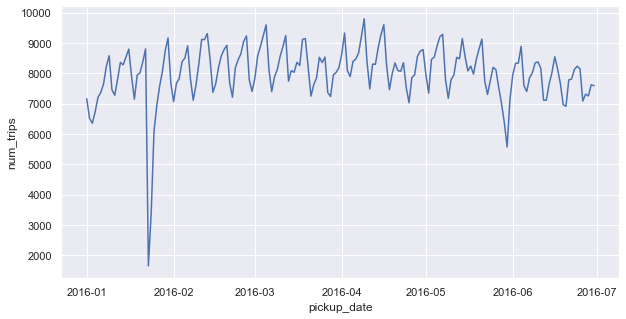

In [15]:
plt.figure(figsize = (10,5))
sns.lineplot(data = num_trips_date, x = 'pickup_date', y = 'num_trips')

На графике выделяются два периода с аномально маленьким количеством поездок. Вычислим эти даты.

In [16]:
x = pd.Timestamp(2016,4,26)

In [17]:
# Поиск аномалий в период 2016.01.00 - 2016.04.00
num_trips_date\
            .query('pickup_date <= @x')\
            .sort_values('num_trips').head(4)

,pickup_date,num_trips
22,2016-01-23,1648
23,2016-01-24,3383
24,2016-01-25,6084
2,2016-01-03,6353


In [18]:
# Поиск аномалий в период 2016.04.00 - 2016.07.00
num_trips_date\
            .query('pickup_date >= @x')\
            .sort_values('num_trips').head(4)

,pickup_date,num_trips
150,2016-05-30,5570
149,2016-05-29,6372
171,2016-06-20,6910
170,2016-06-19,6962


Используя google удалось узнать следующие факты:

* **2016.01.23 - 2016.01.24**: Восток США пережил сильнейшие снегопады за столетие (Первая аномалия на графике). Потенциально влияет на длительность поездки
* **2015.05.30**: не удалось найти информации в открытых источниках

Посмотрим, влияют ли данные периоды на зависимость среднего логарифма продолжительности поездки от дня в году

In [19]:
# Средний логарифм продолжительности поездки от дня в году
time_trips_date = train\
                .groupby('pickup_date', as_index =False)\
                .agg({'log_trip_duration':'mean'})\
                .rename(columns = {'log_trip_duration':'mean_time_trips_date'})

<AxesSubplot:xlabel='pickup_date', ylabel='mean_time_trips_date'>

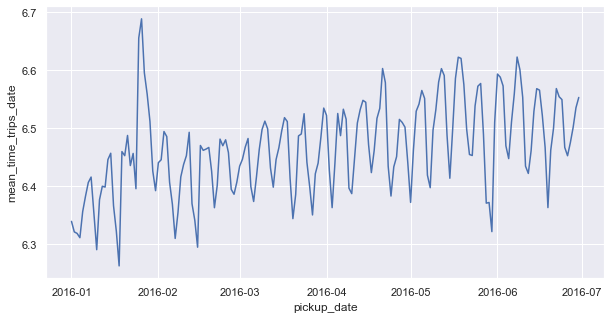

In [20]:
plt.figure(figsize = (10,5))
sns.lineplot(data = time_trips_date, x = 'pickup_date', y = 'mean_time_trips_date')

На графике выделяется период **2016.01.23 - 2016.01.24**. Предположение: снегопад вызвал пробки в городе, что непосредственно повлияло на продолжительность поездки. 

Создадим новый фактор **anomaly**. 1 - поездка совершалась в период обильных снегопадов, 0 - иначе

Нельзя не учесть наблюдаемый тренд, со временем длительность поездки увеличивается.

In [21]:
train['day_of_year'] = train['pickup_datetime'].apply(lambda x: x.day_of_year)
test['day_of_year'] = test['pickup_datetime'].apply(lambda x: x.day_of_year)

In [22]:
def anomaly(x):
    if (str(x) == '2016-01-23') or (str(x) == '2016-01-24'):
        return 1
    else:
        return 0

In [23]:
train['anomaly'] = train['pickup_date'].apply(anomaly)
test['anomaly'] = test['pickup_date'].apply(anomaly)

**Посмотрим на зависимость {Количество поездок; Cредний логарифм продолжительности поездки} от часа дня**

In [24]:
train['pickup_hour'] = train['pickup_datetime'].dt.hour
test['pickup_hour'] = test['pickup_datetime'].dt.hour

In [25]:
# Количество поездок в зависимости от часа дня
num_trips_hour = train\
                    .groupby('pickup_hour', as_index = False)\
                    .agg({'id':'count'})\
                    .rename(columns = {'id':'num_trips'})

# Средний логарифм продолжительности поездки от часа дня
time_trips_hour = train\
                .groupby('pickup_hour', as_index =False)\
                .agg({'log_trip_duration':'mean'})\
                .rename(columns = {'log_trip_duration':'mean_time_trips_hour'})

<AxesSubplot:xlabel='pickup_hour', ylabel='mean_time_trips_hour'>

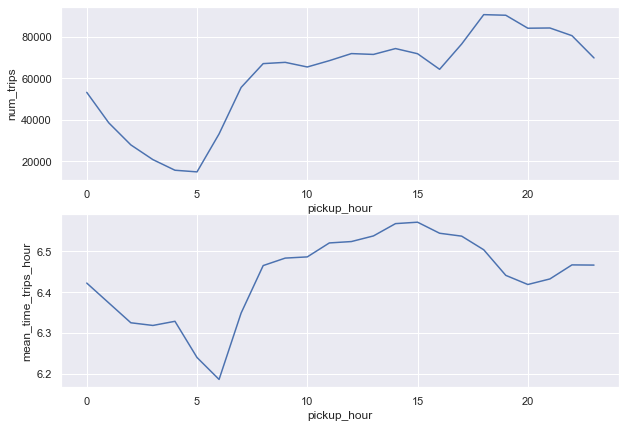

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))

# График зависимости количества поездок от часа дня
sns.lineplot(x = 'pickup_hour', y = 'num_trips', data = num_trips_hour, ax = axes[0])

# График зависимости среднего логарифма времени поездки от часа дня
sns.lineplot(x = 'pickup_hour', y = 'mean_time_trips_hour', data = time_trips_hour, ax = axes[1])

На графиках заметна корреляция между количеством поездок и длительностью поездки, в зависимости от часа дня. До 16 часов наблюдается прямая зависимость, она скорее связана с тем, что чем больше поездок в это время в городе, тем сильнее пробки, соответственно длительность поездки увеличивается. С 16 часов до 20 наблюдается обратная зависимость, что вызывает подозрение, возможно корректировки внесли другие факторы, например день недели (цель поездки на такси в будни и выходные в период от 16 до 20 часов у население может меняться, поэтому результат неоднозначный). Для более точного понимания общей картины следует проанализировать день недели, так же будет полезно взглянуть на месяц года.

**Зависимость количества поездок и среднего логарифма длительности поездки от дня недели**

In [27]:
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday

In [28]:
# Количество поездок от дня недели
num_trips_weekday = train\
                    .groupby('pickup_weekday', as_index = False)\
                    .agg({'id':'count'})\
                    .rename(columns = {'id':'num_trips'})

# Средний логарифм продолжительности поездки от дня недели
time_trips_weekday = train\
                .groupby('pickup_weekday', as_index =False)\
                .agg({'log_trip_duration':'mean'})\
                .rename(columns = {'log_trip_duration':'mean_time_trips_weekday'})

<AxesSubplot:xlabel='pickup_weekday', ylabel='mean_time_trips_weekday'>

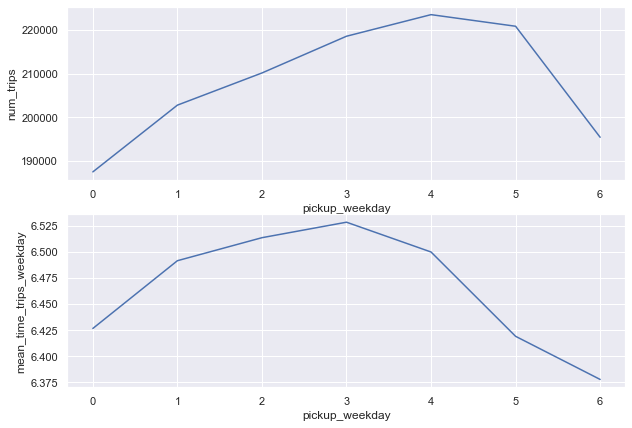

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))

# График зависимости количества поездок от дня недели
sns.lineplot(x = 'pickup_weekday', y = 'num_trips', data = num_trips_weekday, ax = axes[0])

# График зависимости среднего логарифма времени поездки от дня недели
sns.lineplot(x = 'pickup_weekday', y = 'mean_time_trips_weekday', data = time_trips_weekday, ax = axes[1])

На графиках продемонстрированы достаточно очевидные результаты. В выходные количество поездок падает,как и длительности поездки.

Изобразим на графике зависимость количества поездок от часа в сутках для разных дней недели. Тоже самое проделаем для длительности поездки 

In [30]:
num_trips_hour_weekday = train\
                    .groupby(['pickup_hour','pickup_weekday'], as_index = [False, False])\
                    .agg({'id':'count'})\
                    .rename(columns = {'id':'num_trips'})

time_trips_hour_weekday = train\
                .groupby(['pickup_hour','pickup_weekday'], as_index =[False, False])\
                .agg({'log_trip_duration':'mean'})\
                .rename(columns = {'log_trip_duration':'mean_time_trips_hour_weekday'})

<AxesSubplot:xlabel='pickup_hour', ylabel='mean_time_trips_hour_weekday'>

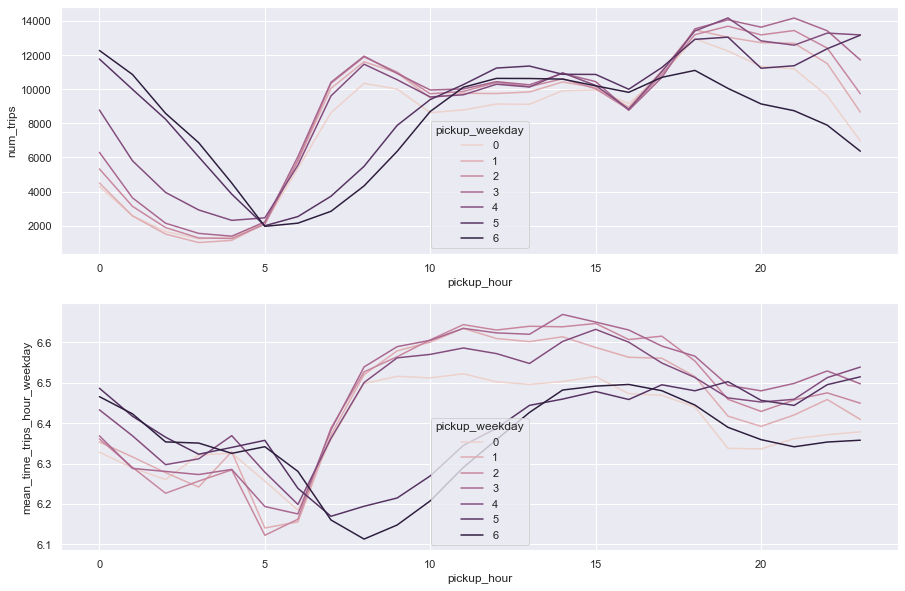

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# График зависимости количества поездок от часа дня для каждого дня недели
sns.lineplot(x = 'pickup_hour', y = 'num_trips', hue = 'pickup_weekday', data = num_trips_hour_weekday, ax = axes[0])

# График зависимости среднего логарифма времени поездки от часа ня для каждого дня недели
sns.lineplot(x = 'pickup_hour', y = 'mean_time_trips_hour_weekday', hue = 'pickup_weekday', data = time_trips_hour_weekday, ax = axes[1])

**Аналогичную работу проведем с месяцем года**

In [32]:
train['pickup_month'] = train['pickup_datetime'].dt.month
test['pickup_month'] = test['pickup_datetime'].dt.month

In [33]:
# Средний логарифм продолжительности поездки от месяца
num_trips_month = train\
                    .groupby('pickup_month', as_index = False)\
                    .agg({'id':'count'})\
                    .rename(columns = {'id':'num_trips'})

# Средний логарифм продолжительности поездки от месяца
time_trips_month = train\
                .groupby('pickup_month', as_index =False)\
                .agg({'log_trip_duration':'mean'})\
                .rename(columns = {'log_trip_duration':'mean_time_trips_month'})

<AxesSubplot:xlabel='pickup_month', ylabel='mean_time_trips_month'>

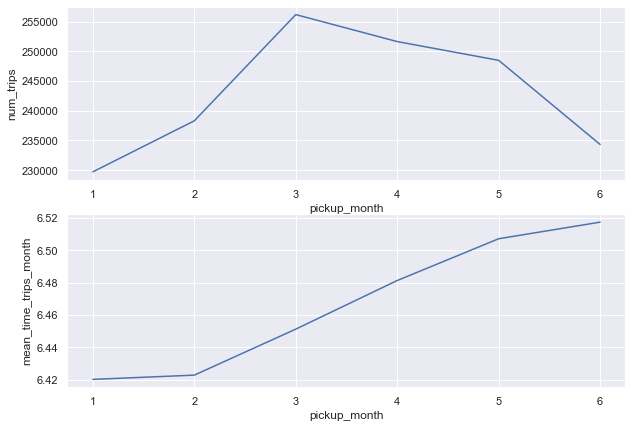

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))

# График зависимости количества поездок от месяца
sns.lineplot(x = 'pickup_month', y = 'num_trips', data = num_trips_month, ax = axes[0])

# График зависимости среднего логарифма времени поездки от месяца
sns.lineplot(x = 'pickup_month', y = 'mean_time_trips_month', data = time_trips_month, ax = axes[1])

In [35]:
num_trips_hour_month = train\
                    .groupby(['pickup_hour','pickup_month'], as_index = [False, False])\
                    .agg({'id':'count'})\
                    .rename(columns = {'id':'num_trips'})

time_trips_hour_month = train\
                .groupby(['pickup_hour','pickup_month'], as_index =[False, False])\
                .agg({'log_trip_duration':'mean'})\
                .rename(columns = {'log_trip_duration':'mean_time_trips_hour_month'})

<AxesSubplot:xlabel='pickup_hour', ylabel='mean_time_trips_hour_month'>

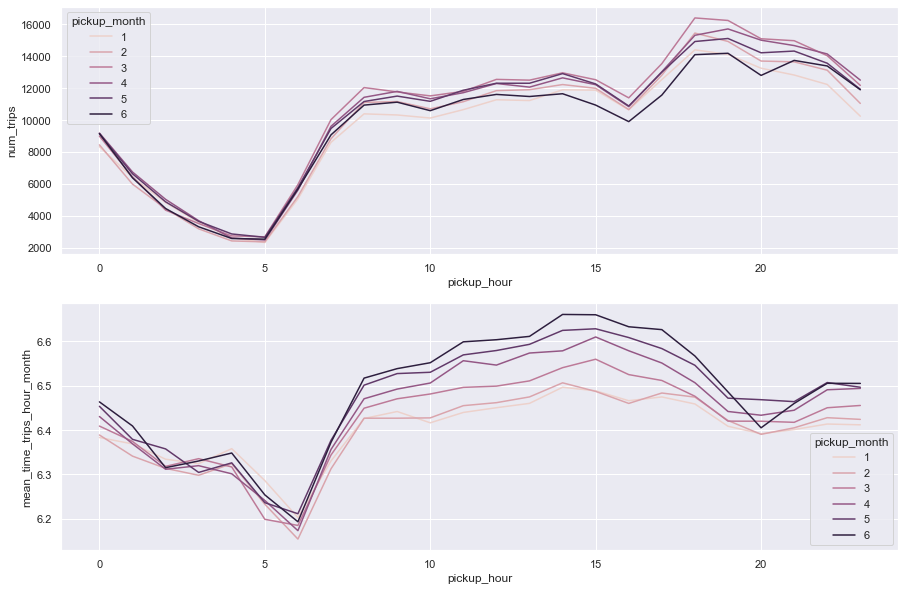

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# График зависимости количества поездок от часа дня для каждого месяца
sns.lineplot(x = 'pickup_hour', y = 'num_trips', hue = 'pickup_month', data = num_trips_hour_month, ax = axes[0])

# График зависимости среднего логарифма времени поездки от часа дня для каждого месяца
sns.lineplot(x = 'pickup_hour', y = 'mean_time_trips_hour_month', hue = 'pickup_month', data = time_trips_hour_month, ax = axes[1])

Вышеприведенный анализ продемонстрировал влияние следующих факторов на длительность поездки:
* День недели
* Месяц
* Час дня
* Является ли период аномальным
* Номер дня в году

## Part 2. Сoordinates

Реализуем функцию **show_circles_on_map**, которая отмечает точки на карте.

In [37]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

In [38]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Map(center=[40.75172792816162, -73.9722596435547], controls=(ZoomControl(options=['position', 'zoom_in_text', …

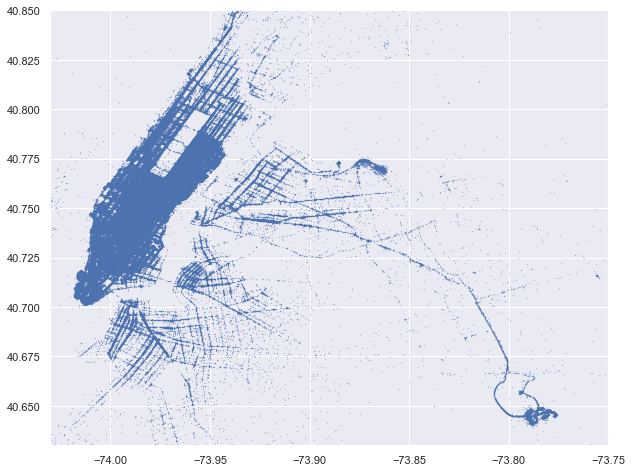

In [39]:
# Отметки на карте, где началась поездка
fig, axes = plt.subplots(1,1,figsize=(10,8))
plt.ylim(40.63, 40.85)
plt.xlim(-74.03,-73.75)
axes.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.02, alpha=1)

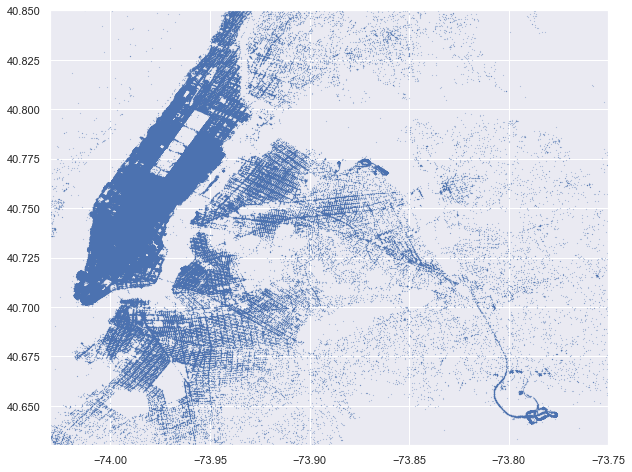

In [40]:
# Отметки на карте, где закочилась поездка
fig, axes = plt.subplots(1,1,figsize=(10,8))
plt.ylim(40.63, 40.85)
plt.xlim(-74.03,-73.75)
axes.scatter(train['dropoff_longitude'],train['dropoff_latitude'], s=0.02, alpha=1)


**Тяжело посчитать точное расстояние, которое преодолело такси за время поездки, но есть спосособ оценить его, достаточно найти кратчайшее расстояние между началом и концом поездки**

In [41]:
train['haversine'] = train.apply(lambda x: haversine((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'],x['dropoff_longitude'])), axis = 1)
test['haversine'] = test.apply(lambda x: haversine((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'],x['dropoff_longitude'])), axis = 1)

Так как таргет - логарифм от длительности поездки, следовательно расстояние также следует логарифмировать. 

In [42]:
train['log_haversine'] = np.log1p(train['haversine'])
test['log_haversine'] = np.log1p(test['haversine'])

In [43]:
# Логарифм расстояния увеличивает корреляцию с таргетом

corr_without_log = train['haversine'].to_frame().corrwith(train['log_trip_duration']).values[0].round(2)
corr_with_log = train['log_haversine'].to_frame().corrwith(train['log_trip_duration']).values[0].round(2)

print(f'Corr(haversine, log_trip_duration) = {corr_without_log}')
print(f'Corr(log_haversine, log_trip_duration) = {corr_with_log}')

Corr(haversine, log_trip_duration) = 0.57
Corr(log_haversine, log_trip_duration) = 0.75


<AxesSubplot:xlabel='log_trip_duration', ylabel='log_haversine'>

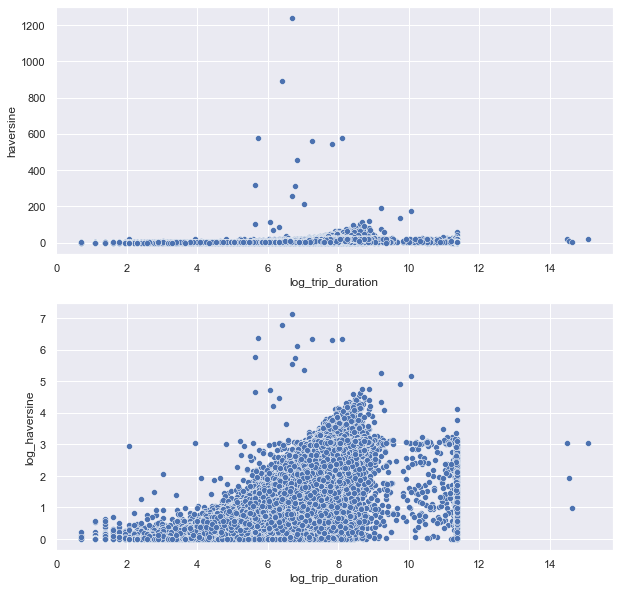

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.scatterplot(y = 'haversine', x = 'log_trip_duration', data = train, ax = axes[0])
sns.scatterplot(y = 'log_haversine', x = 'log_trip_duration', data = train, ax = axes[1])

**Средняя скорость поездки**

<AxesSubplot:xlabel='avg_speed', ylabel='Count'>

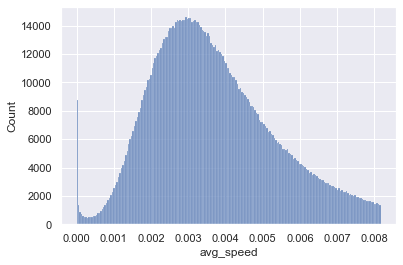

In [45]:
train['avg_speed'] = train['haversine']/train['trip_duration']

sns.histplot(train[train.avg_speed < np.quantile(train.avg_speed, q = 0.95)].avg_speed)

Для каждой пары (день недели, час суток) посчитаем медиану скоростей.

In [46]:
med_weekday_hour_speed = train\
                        .groupby(['pickup_weekday','pickup_hour'], as_index = False)\
                        .agg({'avg_speed':'median'})\
                        .rename(columns = {'avg_speed':'median_avg_speed'})

In [47]:
hour_weekday_speed = pd.pivot_table(data = med_weekday_hour_speed, 
                                    values = 'median_avg_speed', 
                                    index = 'pickup_hour',
                                    columns = 'pickup_weekday')

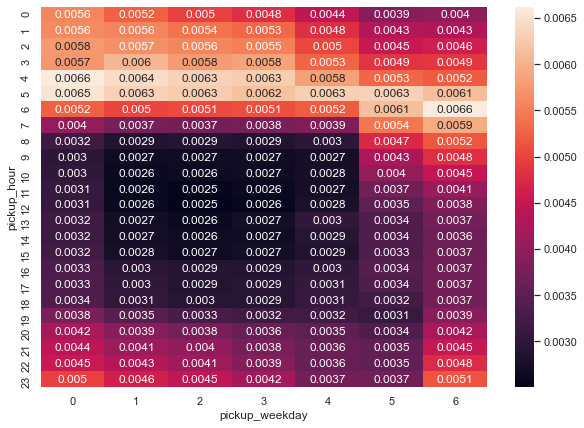

In [48]:
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.heatmap(hour_weekday_speed, annot = True)

C 8 до 20 наблюдается период пробок, так как медиана скоростей в это время значительно уменьшается.

In [49]:
train['high_traffic'] = train['pickup_hour'].apply(lambda x: 1 if  8 <= x <= 20 else 0)
test['high_traffic'] = test['pickup_hour'].apply(lambda x: 1 if 8 <= x <= 20 else 0)

**Аэропорт `La Guardia` & `John F Kennedy`**

На карте выделяются два аэропорта `La Guardia` & `John F Kennedy`. 
Создадим бинарные признаки, идентифицирующие начало или конец поездки в одном из них.
<img src="data/airport.png" width="400" height="400" align="center">

In [50]:
def Guardia_check(latitude, longitude):
    if (40.7663 < latitude < 40.7832) and (-73.8902 < longitude < -73.8524):
        return 1
    else: 
        return 0

In [51]:
def Kennedy_check(latitude, longitude):
    if (40.6204 < latitude < 40.6657) and (-73.8223 < longitude < -73.7456):
        return 1
    else: 
        return 0

In [52]:
train['john_start'] = train.apply(lambda x:  Kennedy_check(x['pickup_latitude'],x['pickup_longitude']), axis = 1)
train['john_end'] = train.apply(lambda x:  Kennedy_check(x['dropoff_latitude'],x['dropoff_longitude']), axis = 1)
                       
test['john_start'] = test.apply(lambda x:  Kennedy_check(x['pickup_latitude'],x['pickup_longitude']), axis = 1)
test['john_end'] = test.apply(lambda x:  Kennedy_check(x['dropoff_latitude'],x['dropoff_longitude']), axis = 1)


In [53]:
train['guardia_start'] = train.apply(lambda x:  Guardia_check(x['pickup_latitude'],x['pickup_longitude']), axis = 1)
train['guardia_end'] = train.apply(lambda x:  Guardia_check(x['dropoff_latitude'],x['dropoff_longitude']), axis = 1)
                       
test['guardia_start'] = test.apply(lambda x:  Guardia_check(x['pickup_latitude'],x['pickup_longitude']), axis = 1)
test['guardia_end'] = test.apply(lambda x:  Guardia_check(x['dropoff_latitude'],x['dropoff_longitude']), axis = 1)

Оценка важности признаков. Построим boxplot

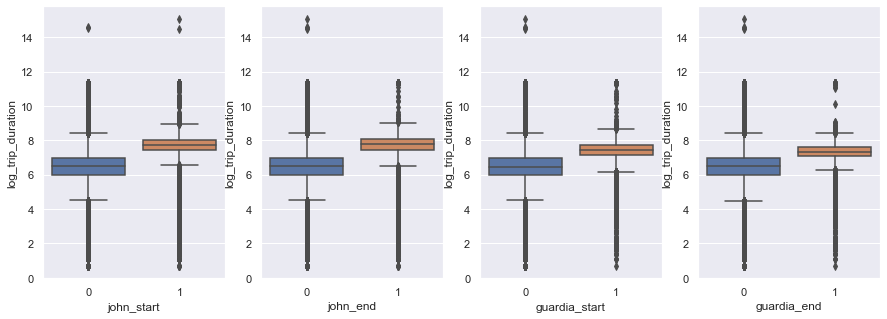

In [54]:
aeroports = ['john_start', 'john_end','guardia_start','guardia_end']

fix, axes = plt.subplots(1,4, figsize = (15,5))
for i,j in enumerate(aeroports):
    sns.boxplot(x = j, y = 'log_trip_duration', data = train, ax = axes[i])

Поездка, начинающаяся или заканчивающаяся в аэропорту, отличается своей длительностью, что продемонстрировано на графиках boxplot.

**Разобьем область в которой сконцентрировано большинство поездок на 12 подобластей.**

Каждой точке поставим в соответствие номер подобласти, если же точка не попала ни в одну подобласть - значение -1


<img src="data/granica.png" width="300" height="300" align="center">


In [55]:
min_latitude = 40.7
max_latitude = 40.8
min_longitude = -74.02
max_longitude = -73.95

In [56]:
latitudes = np.linspace(min_latitude, max_latitude, 5)
longitudes = np.linspace(min_longitude, max_longitude , 4)

In [57]:
def district(lat, long):
    if (min_latitude <= lat <= max_latitude) and (min_longitude <= long <= max_longitude):
        district = 9
        for i in range(1,4):                
                for k in range(1,5):
                    district += 1
                    if long <= longitudes[i] and lat <= latitudes[k]:
                        return district  
    else:
        return -1

In [58]:
# Каждой координате (начало, окончание поздки), поставим в соответствие район. (нумерация от 10 до 22)
train['pickup_district'] = train[['pickup_latitude','pickup_longitude']]\
                                            .apply(lambda x: district(x['pickup_latitude'], x['pickup_longitude']), axis = 1)
test['pickup_district'] = test[['pickup_latitude','pickup_longitude']]\
                                            .apply(lambda x: district(x['pickup_latitude'], x['pickup_longitude']), axis = 1)
    
train['dropoff_district'] = train[['dropoff_latitude','dropoff_longitude']]\
                                            .apply(lambda x: district(x['dropoff_latitude'], x['dropoff_longitude']), axis = 1)
test['dropoff_district'] = test[['dropoff_latitude','dropoff_longitude']]\
                                            .apply(lambda x: district(x['dropoff_latitude'], x['dropoff_longitude']), axis = 1)

Имеет большой смысл добавить фактор - маршрут. 

In [59]:
train['path'] = train[['pickup_district','dropoff_district']].apply(lambda x: str(x[0]) + '_' + str(x[1]), axis = 1)
test['path'] = train[['pickup_district','dropoff_district']].apply(lambda x: str(x[0]) + '_' + str(x[1]), axis = 1)

Добавим признак **short_path**. 1 : поездка началась и закончилась в одном районе, 0 : иначе

In [60]:
train['short_path'] = train[['pickup_district','dropoff_district']].apply(lambda x:  int(x[0] == x[1]), axis = 1)
test['short_path'] = train[['pickup_district','dropoff_district']].apply(lambda x: int(x[0] == x[1]), axis = 1)

<AxesSubplot:xlabel='short_path', ylabel='log_trip_duration'>

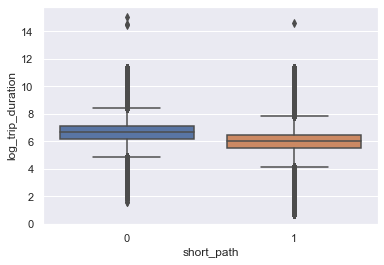

In [61]:
sns.boxplot(x = 'short_path', y = 'log_trip_duration', data = train)

**Где, как ни в этой задаче, применить Манхэттенское расстояние**

Cложность состоит в том, что Манхэттен наклонен на 29 градусов от часовой стрелки, указывающий на север. Следовательно, считать нужно скорректированное Манхэттенское расстояние. 

Справка (Манхэттен):
* 1 градус широты равен 69 милям или 111 км
* 1 градус долготы равен 50 милям или 80 км

In [62]:
train['diff_latitude'] = (train['dropoff_latitude'] - train['pickup_latitude']).abs()*111
test['diff_latitude'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()*111

train['diff_longitude'] = (train['dropoff_longitude'] - train['pickup_longitude']).abs()*80
test['diff_longitude'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()*80

Используем тригонометрию для корректировки расстояния

In [63]:
meas_ang = 0.506 # 29 градусов = 0.506 радиан

def manh_features(df):
    df['Euclidean'] = (df.diff_latitude**2 + df.diff_longitude**2)**0.5 
    df['delta_manh_long'] = (df.Euclidean*np.sin(np.arctan(df.diff_longitude / df.diff_latitude)-meas_ang)).abs()
    df['delta_manh_lat'] = (df.Euclidean*np.cos(np.arctan(df.diff_longitude / df.diff_latitude)-meas_ang)).abs()
    df['manh_length'] = df.delta_manh_long + df.delta_manh_lat

In [64]:
manh_features(train)
manh_features(test)

In [65]:
# Была ли совершена поездка на Манхэттене
def manh_check(x):
    if  40.7091 < x['dropoff_latitude'] < 40.8205 and \
    -74.0096 < x['dropoff_longitude'] < -73.9307 and \
    40.7091 < x['pickup_latitude'] < 40.8205 and \
    -74.0096 < x['pickup_longitude'] < -73.9307:
        return 1
    else:
        return 0

In [66]:
train['manh_island'] = train.apply(manh_check, axis = 1) 
test['manh_island'] = test.apply(manh_check, axis = 1) 

In [67]:
train['log_manh_length'] = np.log1p(train['manh_length'])
test['log_manh_length'] = np.log1p(test['manh_length'])

<AxesSubplot:xlabel='log_trip_duration', ylabel='log_manh_length'>

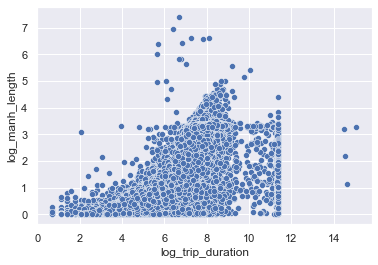

In [68]:
sns.scatterplot(x = 'log_trip_duration', y = 'log_manh_length', data = train)

Какой из методов оценки расстояний дает большую корреляцию

Сравнение корреляций, для поездок которые закончились и начались на Манхэттэне

In [69]:
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

In [70]:
corr_manh_duration_manh = train.query('manh_island == 1 and log_manh_length != 0')['log_manh_length'].to_frame().corrwith(train.query('manh_island == 1 and log_manh_length != 0')['log_trip_duration']).values[0].round(2)
corr_havers_duration_manh = train.query('manh_island == 1 and log_haversine != 0')['log_haversine'].to_frame().corrwith(train.query('manh_island == 1 and log_haversine != 0')['log_trip_duration']).values[0].round(2)

print(f'Corr(log_manh_length, log_trip_duration) = {corr_manh_duration_manh}')
print(f'Corr(log_haversine, log_trip_duration) = {corr_havers_duration_manh}')

Corr(log_manh_length, log_trip_duration) = 0.71
Corr(log_haversine, log_trip_duration) = 0.69


Сравнение корреляций, для поездок которые закончились и начались не на Манхэттане

In [71]:
corr_manh_duration_not_manh = train.query('manh_island == 0 and log_manh_length != 0')['log_manh_length'].to_frame().corrwith(train.query('manh_island == 0 and log_manh_length != 0')['log_trip_duration']).values[0].round(4)
corr_havers_duration_not_manh = train.query('manh_island == 0 and log_haversine != 0')['log_haversine'].to_frame().corrwith(train.query('manh_island == 0 and log_haversine != 0')['log_trip_duration']).values[0].round(4)

print(f'Corr(log_manh_length, log_trip_duration) = {corr_manh_duration_not_manh}')
print(f'Corr(log_haversine, log_trip_duration) = {corr_havers_duration_not_manh}')

Corr(log_manh_length, log_trip_duration) = 0.8018
Corr(log_haversine, log_trip_duration) = 0.799


В обоих случаях, Манхэттенское расстояние дает большую корреляцию с таргетом

## Part 3. Other Factors
Осталось проанализировать три признака:
* passenger_count
* store_and_fwd_flag
* vendor_id

**passenger_count**

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

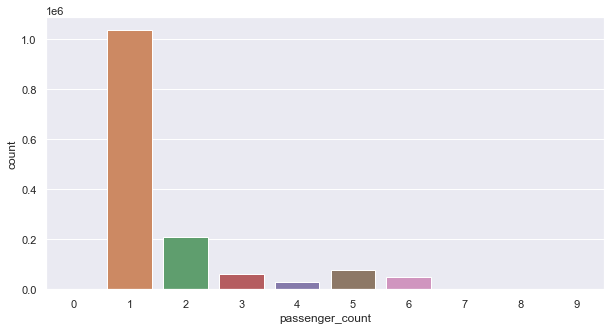

In [72]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'passenger_count', data = train)

In [73]:
train\
.groupby('passenger_count', as_index = False)\
.agg({'id':'count'})

,passenger_count,id
0,0,60
1,1,1033540
2,2,210318
3,3,59896
4,4,28404
5,5,78088
6,6,48333
7,7,3
8,8,1
9,9,1


Большинство поездок включает 1-2 пассажира

<AxesSubplot:xlabel='passenger_count', ylabel='log_trip_duration'>

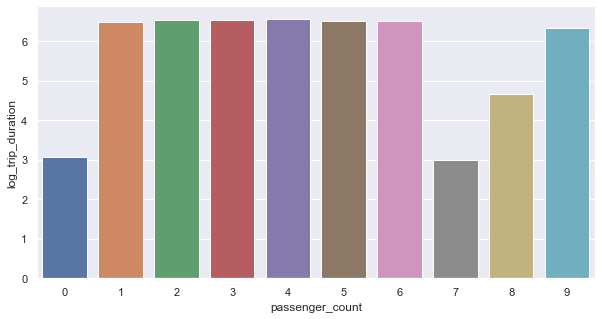

In [74]:
# Взаимосвязь количества пассажиров и длительности поездки
plt.figure(figsize = (10,5))

passenger_count_trip_duration = train\
                                    .groupby('passenger_count', as_index = False)\
                                    .agg({'log_trip_duration':'median'})

sns.barplot(x = 'passenger_count', y = 'log_trip_duration', data = passenger_count_trip_duration)

**store_and_fwd_flag**

In [75]:
train\
.groupby('store_and_fwd_flag', as_index = False)\
.agg({'id':'count'})

,store_and_fwd_flag,id
0,N,1450599
1,Y,8045


<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='log_trip_duration'>

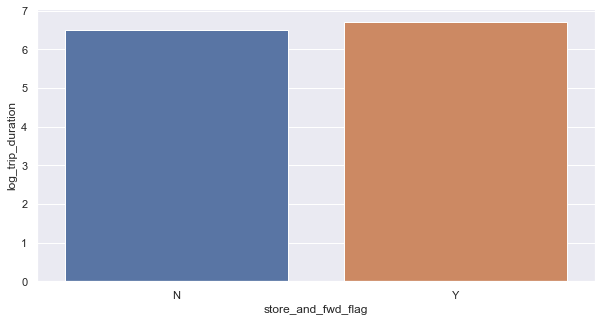

In [76]:
# Взаимосвязь количества пассажиров и длительности поездки
plt.figure(figsize = (10,5))

flag_trip_duration = train\
                        .groupby('store_and_fwd_flag', as_index = False)\
                        .agg({'log_trip_duration':'median'})

sns.barplot(x = 'store_and_fwd_flag', y = 'log_trip_duration', data = flag_trip_duration)

**vendor_id**

<AxesSubplot:xlabel='vendor_id', ylabel='log_trip_duration'>

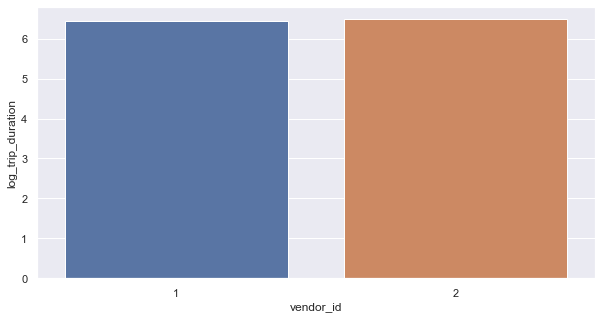

In [77]:
plt.figure(figsize = (10,5))

vendor_trip_duration = train\
                        .groupby('vendor_id', as_index = False)\
                        .agg({'log_trip_duration':'mean'})

sns.barplot(x = 'vendor_id', y = 'log_trip_duration', data = vendor_trip_duration)

## Part 4. Searching for anomalies

**trip_duration**

<AxesSubplot:xlabel='trip_duration'>

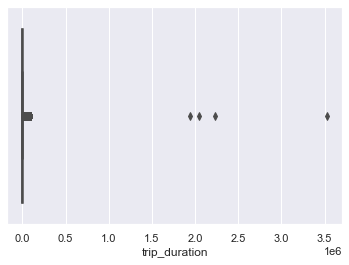

In [78]:
sns.boxplot(x = 'trip_duration', data = train)

<AxesSubplot:xlabel='trip_duration'>

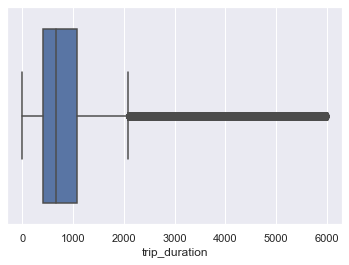

In [79]:
sns.boxplot(x = 'trip_duration', data = train[train.trip_duration < 6000])

Уберем из выборки те поездки, которые превышали 6000 секунд = 1.7 часов

In [80]:
train = train[train.trip_duration < 6000]

**Координаты**

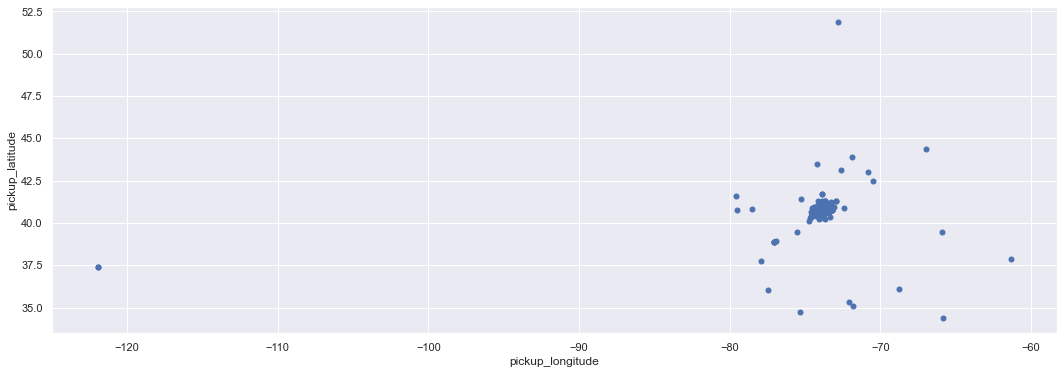

In [81]:
# Начало поездки
pickup_longitude = list(train.pickup_longitude)
pickup_latitude = list(train.pickup_latitude)

plt.subplots(figsize=(18,6))
plt.plot(pickup_longitude, pickup_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.show()

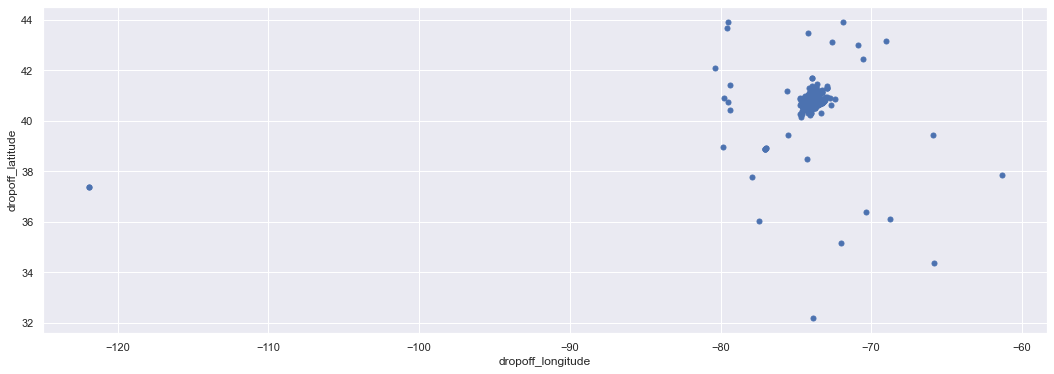

In [82]:
# Конец поездки
dropoff_longitude = list(train.dropoff_longitude)
dropoff_latitude = list(train.dropoff_latitude)

plt.subplots(figsize=(18,6))
plt.plot(dropoff_longitude, dropoff_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.show()

In [83]:
# Избавимся от аномальных значений
train = train[(train.pickup_longitude > -90)]
train = train[(train.pickup_latitude < 50)]

train = train[(train.dropoff_longitude > -90)]
train = train[(train.dropoff_latitude < 50)]

## Part 5. Rare Categories
Модель может переобучиться на редких категориях, следовательно редкие категории можно объединить в одну

In [84]:
# passenger_count
train.passenger_count.value_counts()

1    1031962
2     209915
5      77849
3      59759
6      48190
4      28335
0         59
7          3
8          1
9          1
Name: passenger_count, dtype: int64

Редким категориям присвоим значение -1

In [85]:
train['passenger_count'] = train['passenger_count'].apply(lambda x: -1 if (x in [7,8,9,0]) else x)
test['passenger_count'] = test['passenger_count'].apply(lambda x: -1 if (x in [7,8,9,0]) else x)

In [86]:
# path
train.path.value_counts().sort_values()

14_13        1
17_13        2
20_13        2
15_13        3
12_13        3
         ...  
15_16    53091
20_20    56229
-1_-1    75223
15_15    80695
16_16    99246
Name: path, Length: 153, dtype: int64

Оставим 90 маршрутов, самым редким 60 маршрутам присвоим значение -1

In [87]:
rare_path = train.path.value_counts().sort_values().to_frame().reset_index().iloc[:60,:]['index'].values

In [88]:
train['path'] = train['path'].apply(lambda x: -1 if x in rare_path else x)
test['path'] = test['path'].apply(lambda x: -1 if x in rare_path else x)

## Part 6. Feature transformation

In [89]:
# Трансформируем признак store_and_fwd_flag в бинарный 
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'Y' : 1, 'N' : 0})
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'Y' : 1, 'N' : 0})

In [90]:
# Отметим бинарнй, категориальные и вещественные признаки

binary = ['vendor_id','store_and_fwd_flag','anomaly','high_traffic',
        'john_start','john_end','guardia_start','guardia_end','short_path','manh_island']

categorical =['passenger_count','pickup_hour','pickup_weekday','pickup_month','path']

numerical = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','manh_length','day_of_year']

In [91]:
# Отберем нужные факторы в обучающую и тестовую выборку
X_train = train[numerical + binary + categorical]
y_train = train['log_trip_duration']

X_test = test[numerical + binary + categorical]

In [92]:
# Преобразование категориальных признаков
train_index = len(X_train)
test_index = len(X_test)

data = pd.concat([X_train, X_test])

data_dummi = pd.get_dummies(data, columns = categorical)

# Итоговые обучающие и тестовые выборки
X_train = data_dummi.iloc[: train_index, :]
X_test = data_dummi.iloc[train_index:, :]
X_test['id'] = test['id'].values

C:\Users\valmi\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [93]:
X_train.to_csv('x_train.csv', index =False)

X_test.to_csv('x_test.csv', index = False)

y_train.to_csv('y_train.csv', index = False)

# <center> Predicting the total ride duration of taxi trips 

## XGBoost

In [94]:
params = {'colsample_bytree': 0.8,
          'colsample_bylevel' : 0.8,
          'max_depth': 14,
          'subsample': 0.8,
          'eta': 0.05,
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'nthread': 4,
          'silent': 1}

In [95]:
import xgboost as xgb

In [96]:
train = xgb.DMatrix(X_train, y_train)

In [97]:
xgb_model = xgb.train(params, train, 600)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

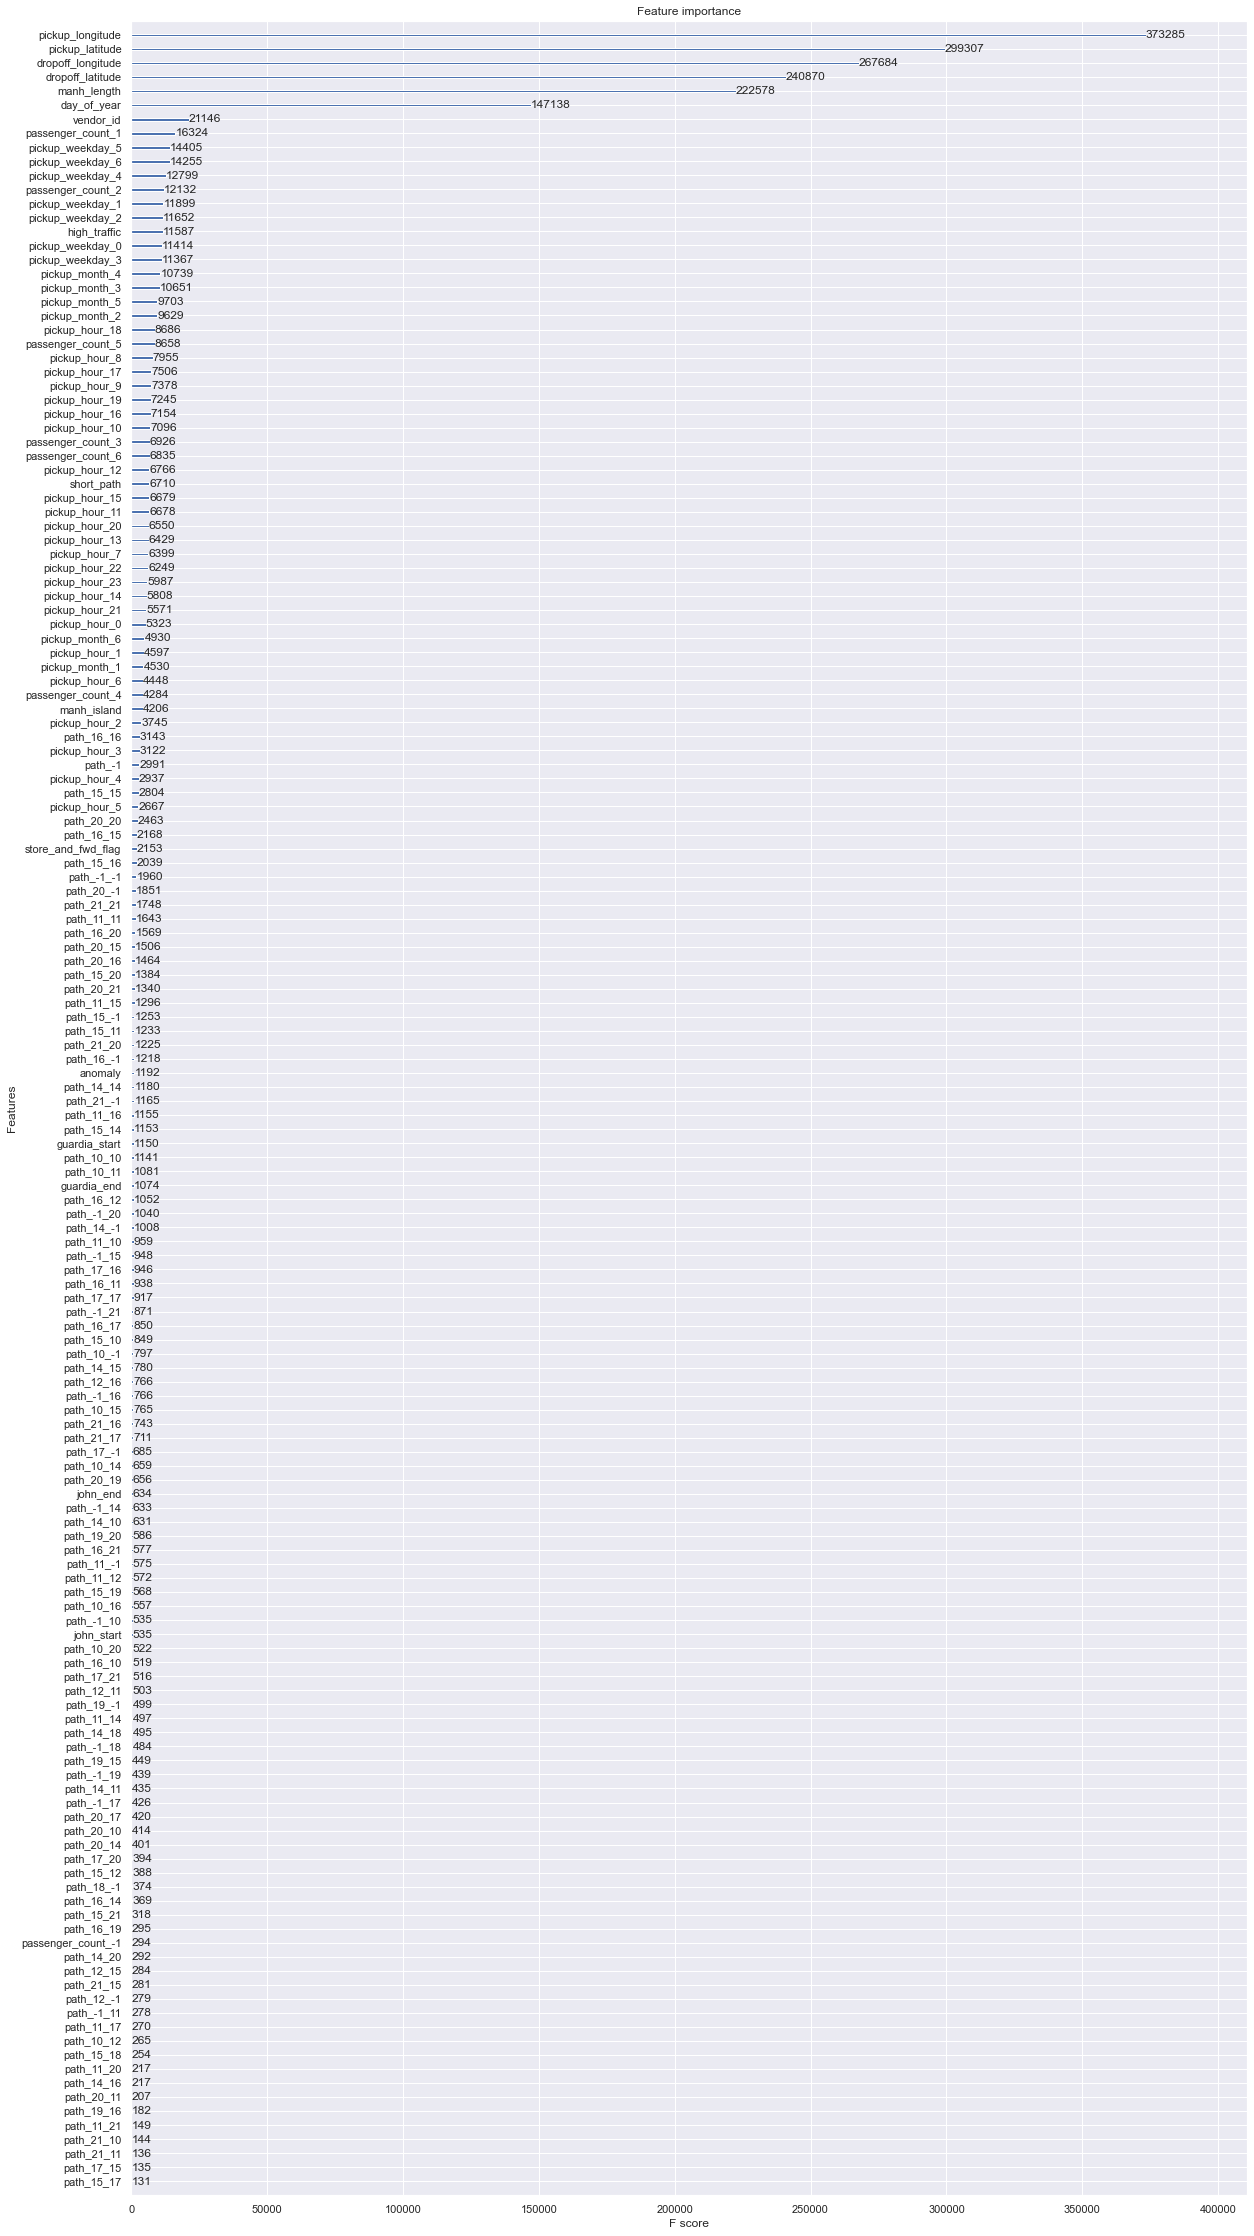

In [98]:
fig, axs = plt.subplots(figsize = (20,40))
xgb.plot_importance(xgb_model,ax = axs)

In [99]:
y_pred = xgb_model.predict(xgb.DMatrix(X_test.drop('id', axis = 1)))

In [100]:
y_pred_norm = np.exp(y_pred) -1

In [101]:
sub = pd.DataFrame()
sub['id'] = X_test.id
sub['trip_duration'] = y_pred_norm
sub.head(3)

,id,trip_duration
0,id3004672,867.814331
1,id3505355,811.051270
2,id1217141,436.703400


In [102]:
sub.to_csv('submission_xgboost.csv', index=False)


**Kaggle score RMSLE :**
* **Private 0.41038**
* **Public 0.41285**

## LightGBM

In [104]:
import lightgbm as lgbm


In [105]:
lgb_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

In [106]:
lgb_df = lgbm.Dataset(X_train,y_train)


In [107]:
lgb_model = lgbm.train(lgb_params, lgb_df, num_boost_round=1500)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.682924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5480
[LightGBM] [Info] Number of data points in the train set: 1456074, number of used features: 154
[LightGBM] [Info] Start training from score 6.459263


In [108]:
y_pred_lgb = lgb_model.predict(X_test.drop('id', axis = 1))

In [109]:
y_pred_lgb_norm = np.exp(y_pred_lgb) - 1


In [110]:
sub_lgb = pd.DataFrame()
sub_lgb['id'] = X_test.id
sub_lgb['trip_duration'] = y_pred_lgb_norm
sub_lgb.head(3)

,id,trip_duration
0,id3004672,813.225463
1,id3505355,814.838904
2,id1217141,433.519459


In [111]:
sub_lgb.to_csv('submission_lgb.csv', index=False)


**Kaggle score RMSLE :**
* **Private 0.40592**
* **Public 0.40759**

## XGBoost + LightGBM

In [114]:
# y_xgb_lgb = 0.4 * y_xgb + 0.6 * y_lgb

y_pred_xgb_lgb = 0.4*y_pred_norm + 0.6 * y_pred_lgb_norm

In [115]:
sub_xgb_lgb = pd.DataFrame()
sub_xgb_lgb['id'] = X_test.id
sub_xgb_lgb['trip_duration'] = y_pred_xgb_lgb
sub_xgb_lgb.head(3)

,id,trip_duration
0,id3004672,835.061010
1,id3505355,813.323844
2,id1217141,434.793041


In [116]:
sub_xgb_lgb.to_csv('submission_xgb_lgb.csv', index=False)

**Kaggle score RMSLE :**
* **Private 0.40290**
* **Public 0.40484**